In [1]:
import multimodal_cci as mmcci
import scanpy as sc
import numpy as np
import pandas as pd
import pickle

#### Load stLearn data objects

In [2]:
stlearn = [
    sc.read_h5ad("/scratch/project/stseq/Levi/mmcci_benchmarking/sample1_new_cci.h5ad"),
    sc.read_h5ad("/scratch/project/stseq/Levi/mmcci_benchmarking/sample2_new_cci.h5ad"),
    sc.read_h5ad("/scratch/project/stseq/Levi/mmcci_benchmarking/sample3_new_cci.h5ad")
]

with open('/scratch/project/stseq/Levi/mmcci_benchmarking/squidpy_sample1.pkl', 'rb') as f:
    squidpy1 = pickle.load(f)

with open('/scratch/project/stseq/Levi/mmcci_benchmarking/squidpy_sample2.pkl', 'rb') as f:
    squidpy2 = pickle.load(f)

with open('/scratch/project/stseq/Levi/mmcci_benchmarking/squidpy_sample3.pkl', 'rb') as f:
    squidpy3 = pickle.load(f)

squidpy_cci = [squidpy1, squidpy2, squidpy3]

stlearn_cci = [sample.uns['per_lr_cci_cell_type'] for sample in stlearn]

In [3]:
from matplotlib import pyplot as plt

colors = {
    'Bcell': plt.colormaps.get_cmap('tab10').colors[0],
    'Tcell': plt.colormaps.get_cmap('tab10').colors[1],
    'luminal_ar': plt.colormaps.get_cmap('tab10').colors[2],
    'mesenchymal': plt.colormaps.get_cmap('tab10').colors[3],
    'stroma': plt.colormaps.get_cmap('tab10').colors[4],
}

In [4]:
stlearn_overalls = [mmcci.it.calculate_overall_interactions(sample) for sample in stlearn_cci]
squidpy_overalls = [mmcci.it.calculate_overall_interactions(sample) for sample in squidpy_cci]

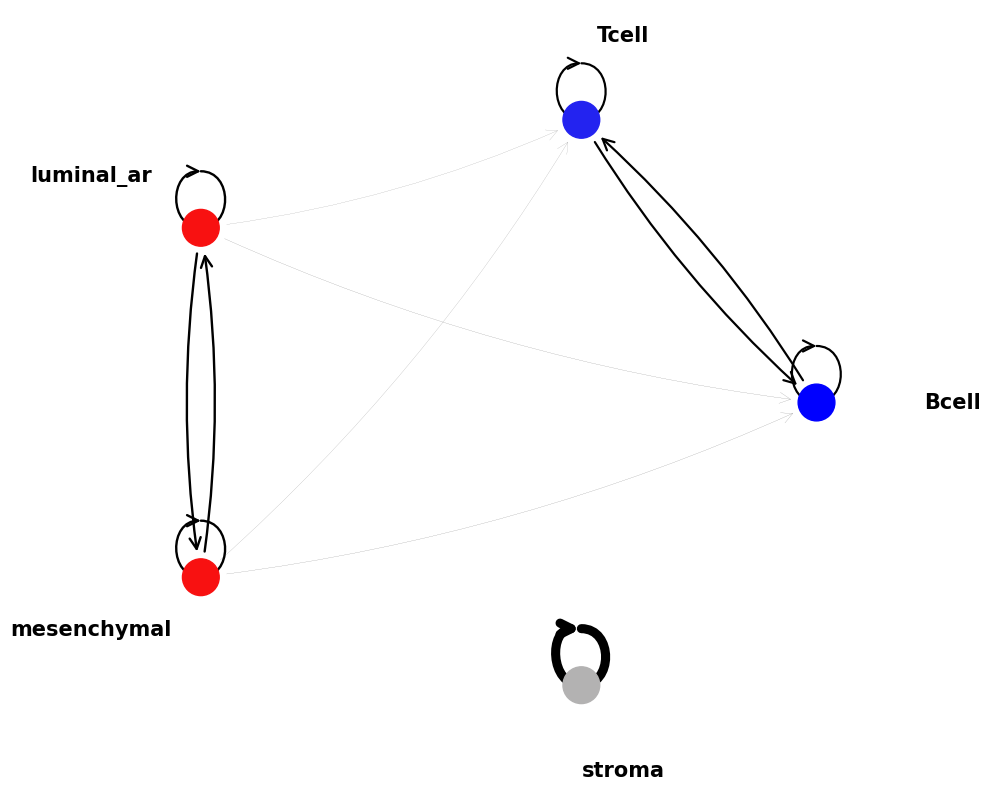

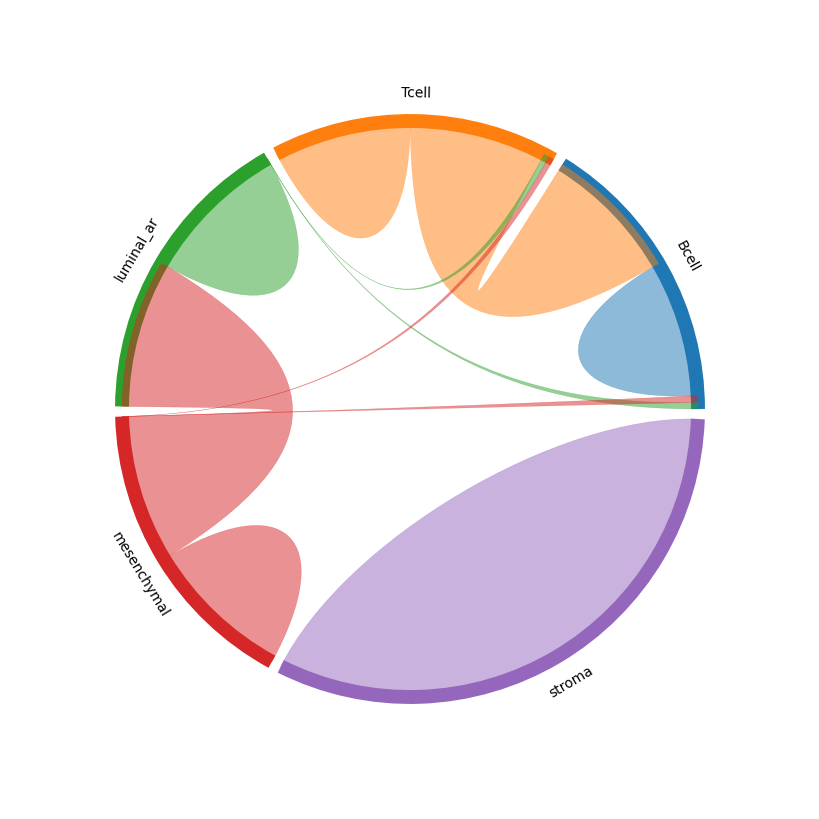

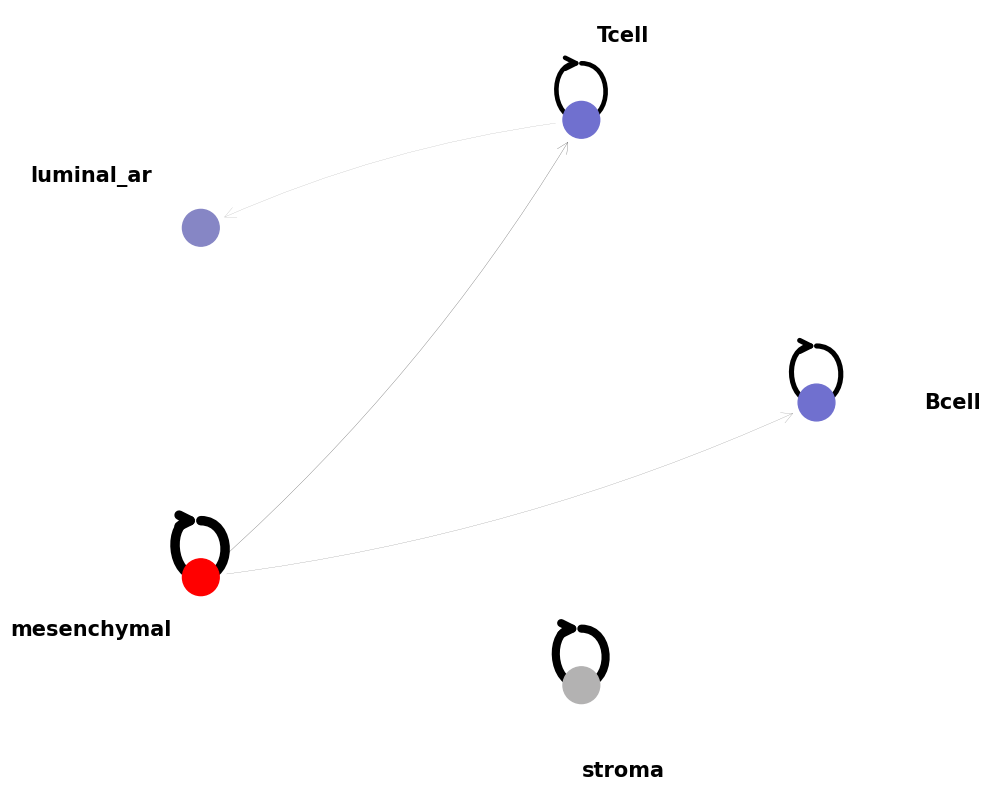

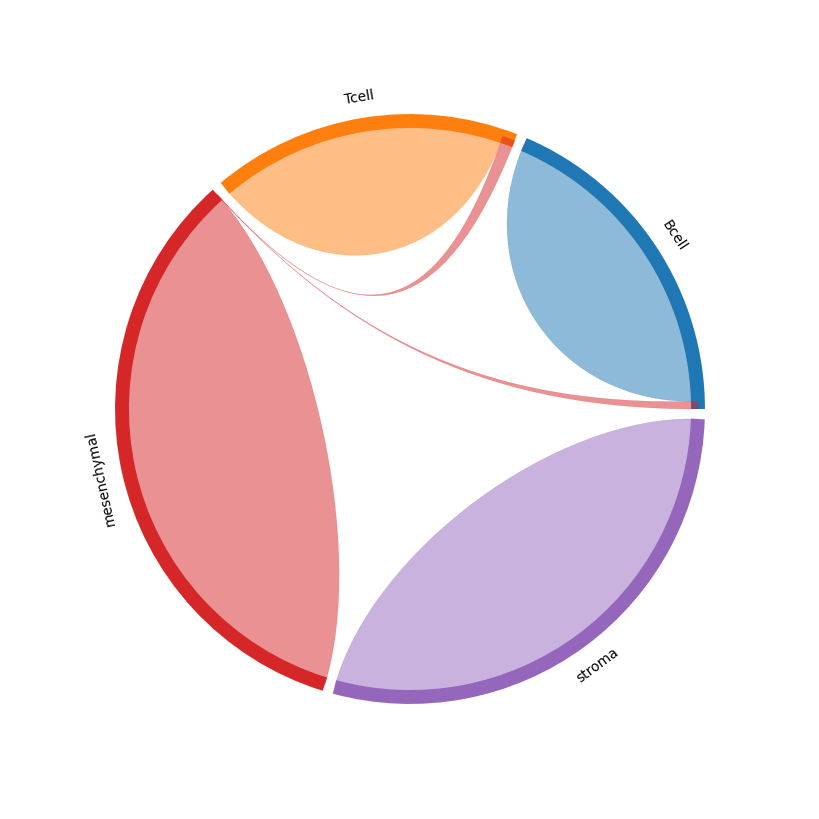

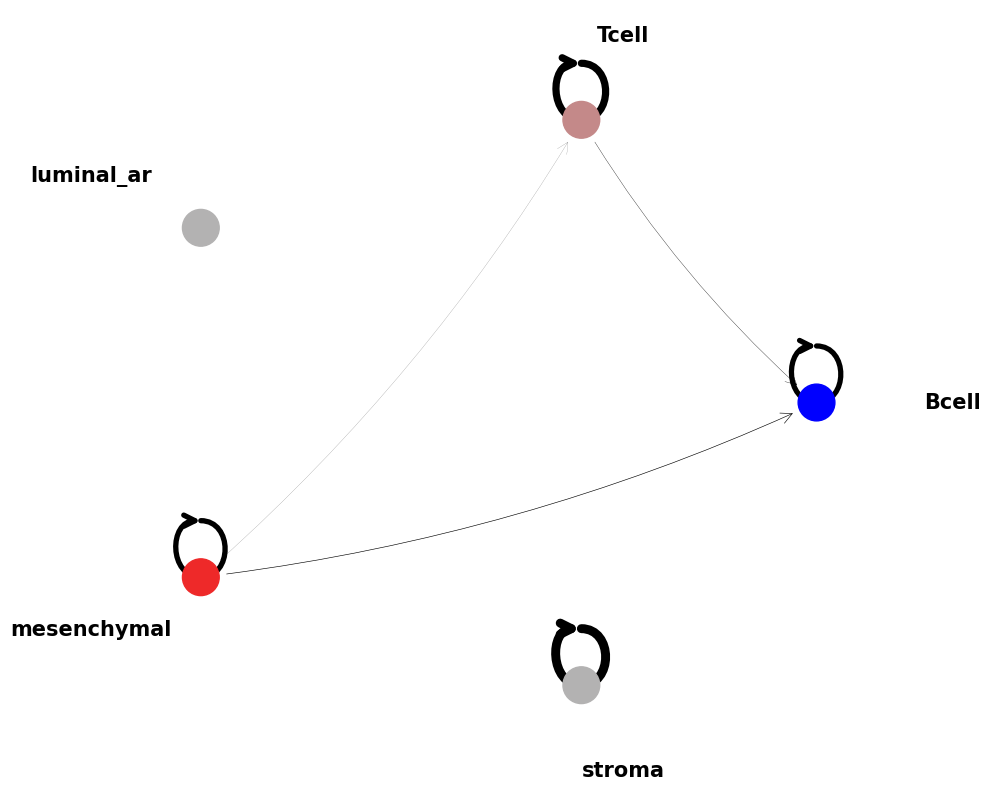

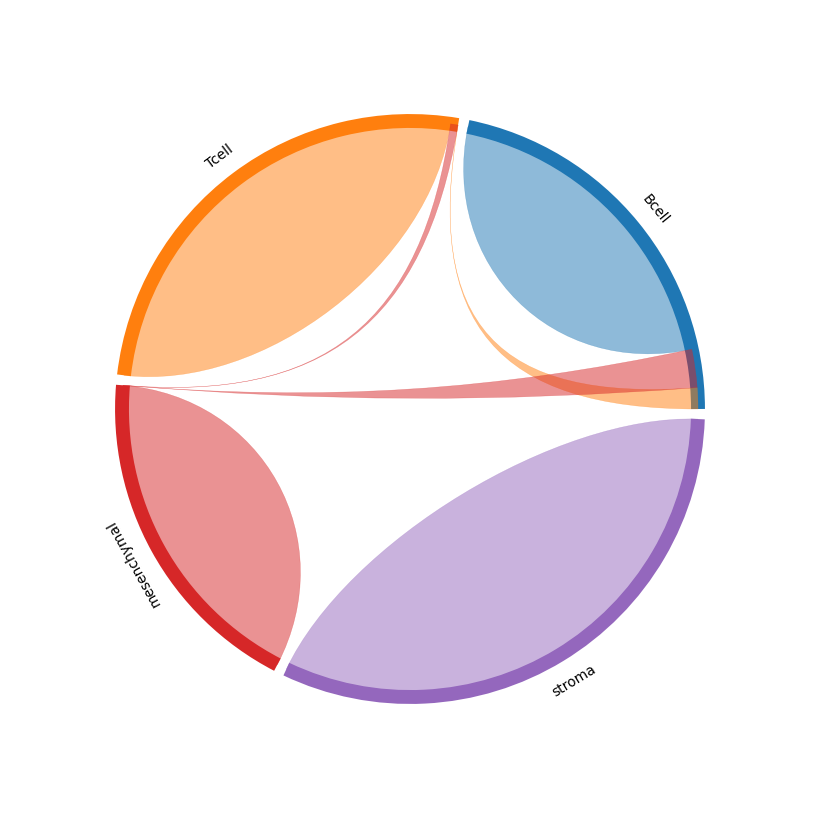

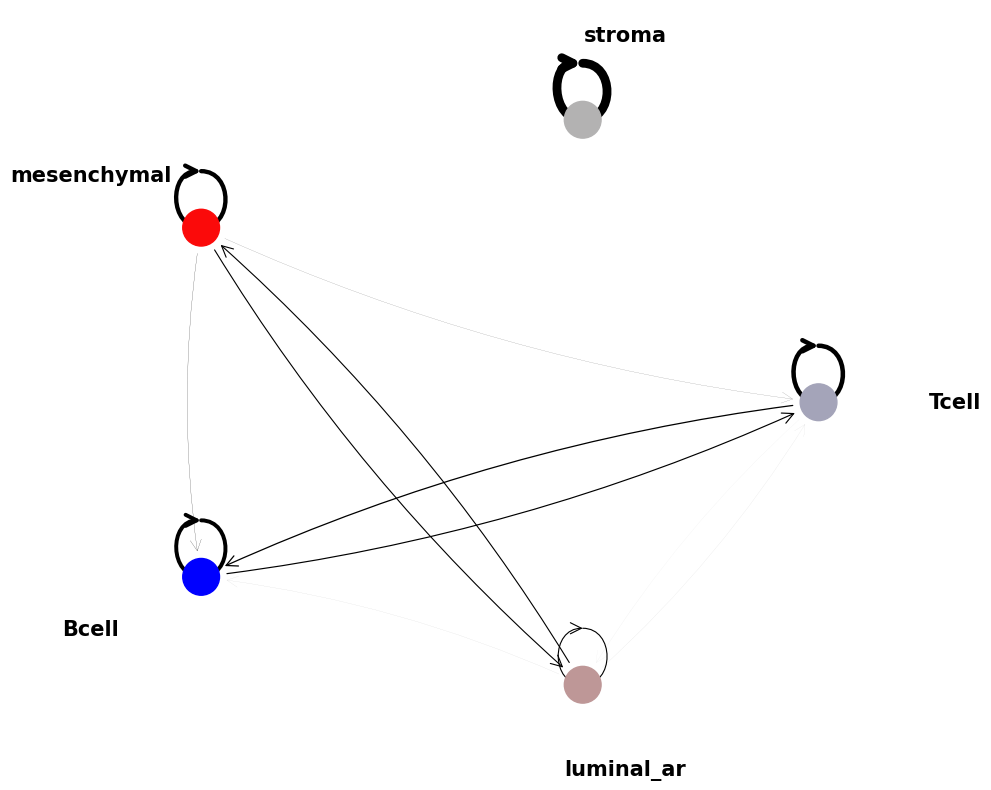

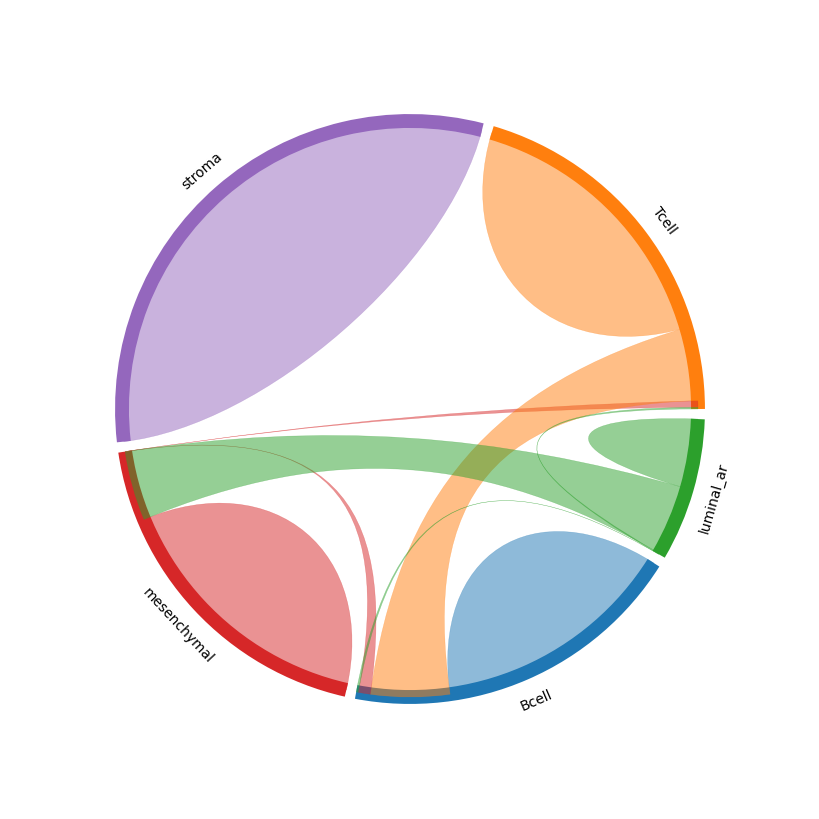

,Tcell,stroma,mesenchymal,Bcell,luminal_ar
Tcell,0.163122,0.000000,0.000000,0.045437,0.000564
stroma,0.000000,0.317062,0.000000,0.000000,0.000000
mesenchymal,0.003714,0.000000,0.156261,0.006971,0.040120
Bcell,0.042235,0.000000,0.000000,0.142056,0.000000
luminal_ar,0.001013,0.000000,0.040120,0.001206,0.040120


In [5]:
lr_pairs = mmcci.it.get_majority_lr_pairs(stlearn_cci)

for sample in stlearn_cci:
    sample = {key: value for key, value in sample.items() if key in lr_pairs}
    sample = mmcci.it.calculate_overall_interactions(sample)
    mmcci.plt.network_plot(sample)
    mmcci.plt.chord_plot(sample, colors=colors)

stlearn_avg = mmcci.it.get_avg_lr_pairs(stlearn_cci, lr_pairs)
stlearn_int = mmcci.it.integrate_between_tech(stlearn_cci)
stlearn_overall = mmcci.it.calculate_overall_interactions(stlearn_avg)
mmcci.plt.network_plot(stlearn_overall)
mmcci.plt.chord_plot(stlearn_overall, colors=colors)
stlearn_overall

In [6]:
print(mmcci.it.get_lrs_per_celltype(stlearn_cci[0], "luminal_ar", "mesenchymal"))
print(mmcci.it.get_lrs_per_celltype(stlearn_cci[1], "luminal_ar", "mesenchymal"))
print(mmcci.it.get_lrs_per_celltype(stlearn_cci[2], "luminal_ar", "mesenchymal"))
print(mmcci.it.get_lrs_per_celltype(stlearn_avg, "luminal_ar", "mesenchymal"))

{'PTPRK_PTPRK': 0.03273322422258593, 'SFRP1_FZD2': 0.031914893617021274, 'DSC3_DSG2': 0.031096563011456628, 'DSG2_DSC3': 0.028846153846153848, 'EPCAM_EPCAM': 0.026800327332242226, 'DSC3_DSG3': 0.022913256955810146, 'SFRP1_FZD6': 0.020867430441898527, 'APP_NCSTN': 0.020867430441898527, 'CXADR_CXADR': 0.019844517184942716, 'SOSTDC1_LRP6': 0.018821603927986905, 'AREG_ERBB3': 0.01820785597381342, 'NRG1_ERBB3': 0.017798690671031098, 'EGF_ERBB3': 0.017798690671031098, 'DSG2_DSC1': 0.01738952536824877, 'DSC1_DSG2': 0.01738952536824877, 'LAMC2_ITGA6': 0.016775777414075287, 'F8_LDLR': 0.016571194762684125, 'EFNA5_EPHB1': 0.015343698854337152, 'EFNA5_EPHA2': 0.014934533551554828, 'APP_TNFRSF21': 0.014729950900163666, 'APP_GPC1': 0.014525368248772505, 'DKK1_LRP6': 0.014320785597381341, 'EFNA5_EPHA1': 0.013707037643207857, 'LAMC2_ITGB4': 0.013297872340425532, 'EFNA5_EPHB6': 0.012274959083469721, 'GNAS_VIPR1': 0.01207037643207856, 'EFNA5_EPHA6': 0.011865793780687398, 'TGFA_ERBB2': 0.011456628477905

In [7]:
print(stlearn_cci[0])
print(stlearn_cci[1])
print(stlearn_cci[2])
print(stlearn_avg)

{'ACE_BDKRB2':              Bcell  Tcell  luminal_ar  mesenchymal  stroma
Bcell            0      0           0            0       0
Tcell            0      0           0            0       0
luminal_ar       0      0           0            0       0
mesenchymal      0      0           0            0       0
stroma           0      0           0            0      29, 'ADAM15_ITGA5':              Bcell  Tcell  luminal_ar  mesenchymal  stroma
Bcell            0      0           0            0       0
Tcell            0      0           0            0       0
luminal_ar       0      0           0            0       0
mesenchymal      0      0           0            0       0
stroma           0      0           0            0      30, 'ADAM17_ITGA5':              Bcell  Tcell  luminal_ar  mesenchymal  stroma
Bcell            0      0           0            0       0
Tcell            0      0           0            0       0
luminal_ar       0      0           0            0       0
mesench

In [8]:
print(stlearn_overalls[0])
print(stlearn_overalls[1])
print(stlearn_overalls[2])
print(stlearn_overall)

                Bcell     Tcell  luminal_ar  mesenchymal    stroma
Bcell        0.055390  0.055390    0.001267     0.001126  0.002206
Tcell        0.055390  0.055390    0.001267     0.001126  0.002206
luminal_ar   0.001632  0.001553    0.048112     0.048357  0.000000
mesenchymal  0.001548  0.001552    0.048112     0.048357  0.000000
stroma       0.003283  0.003283    0.000000     0.000000  0.563457
                Bcell    Tcell  luminal_ar  mesenchymal    stroma
Bcell        0.162791  0.00000    0.000000      0.00000  0.000000
Tcell        0.000000  0.18679    0.002163      0.00000  0.000000
luminal_ar   0.000000  0.00218    0.006541      0.00000  0.000000
mesenchymal  0.003264  0.00540    0.000000      0.30529  0.000000
stroma       0.000000  0.00000    0.000000      0.00000  0.325581
                Bcell     Tcell  luminal_ar  mesenchymal    stroma
Bcell        0.149302  0.000000         0.0     0.000000  0.000000
Tcell        0.008189  0.229605         0.0     0.000000  0.000000
l

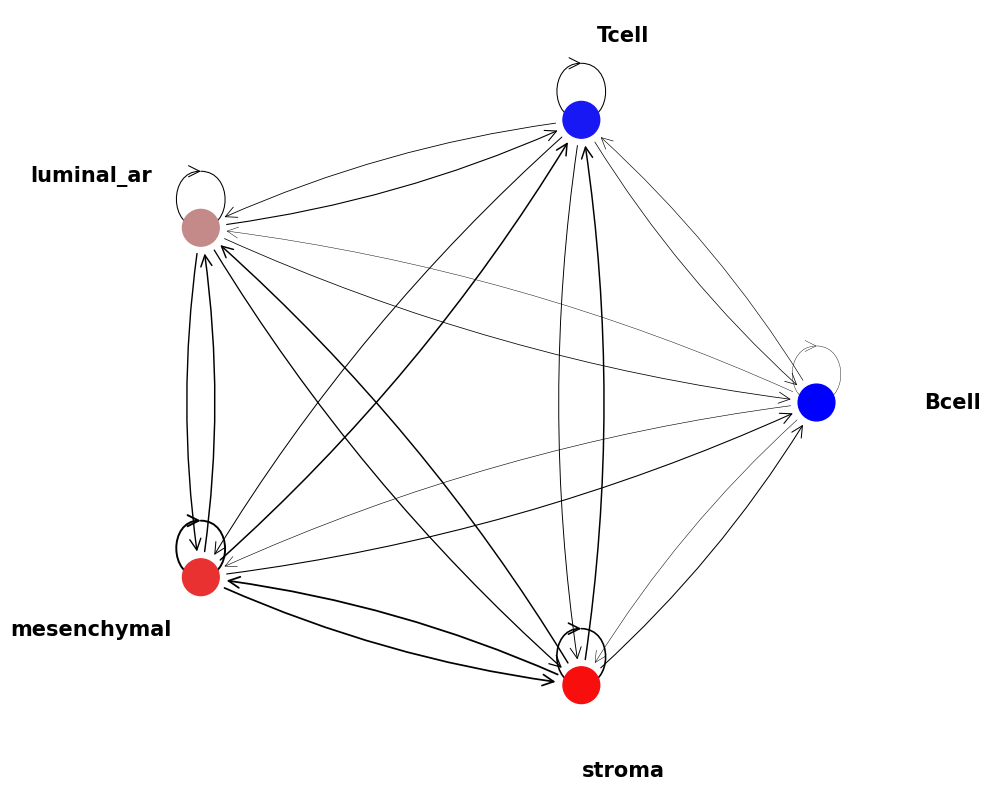

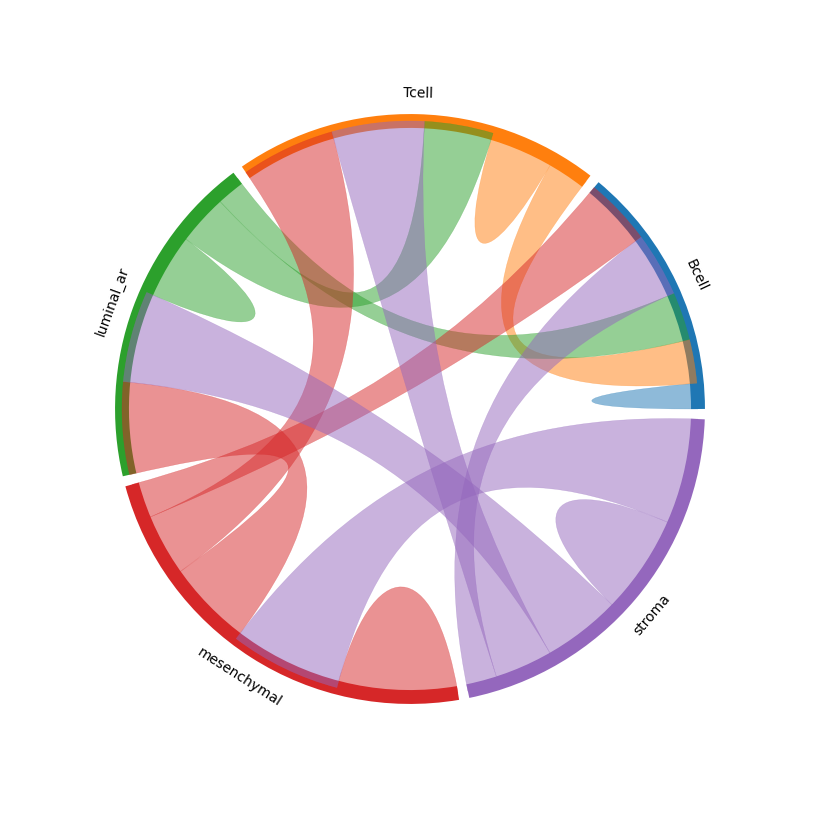

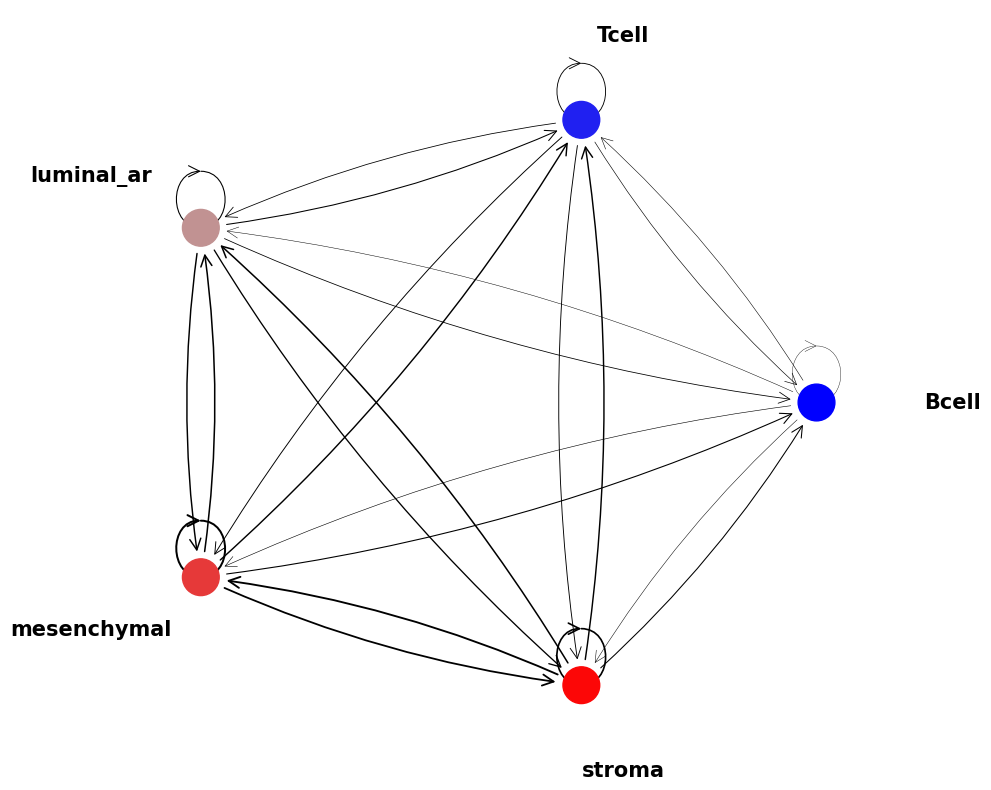

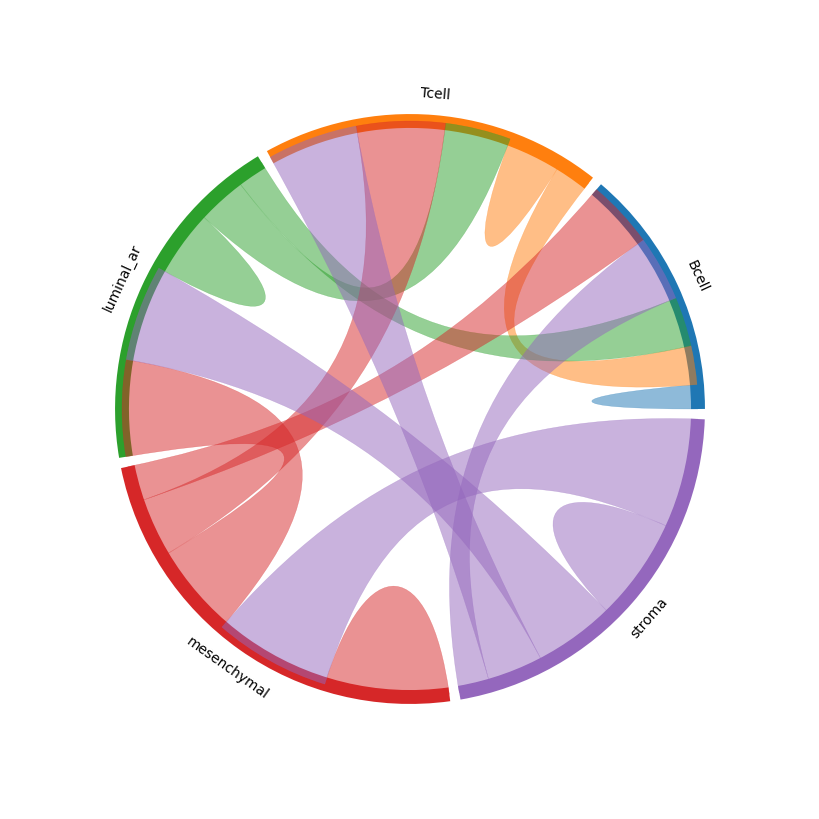

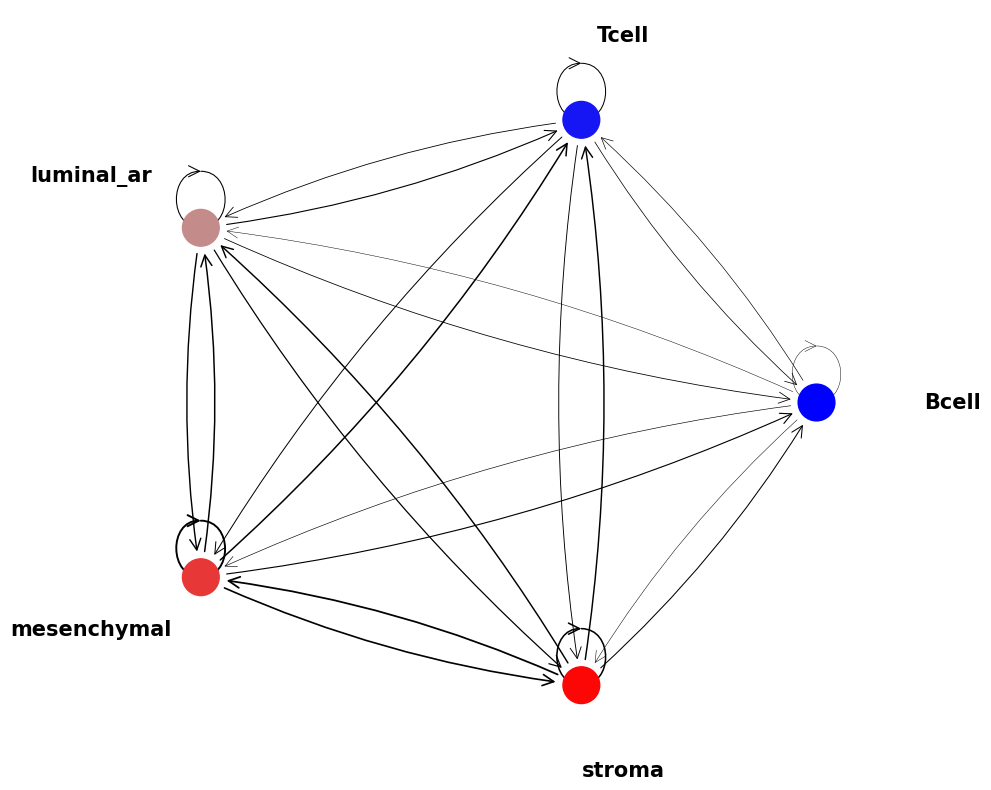

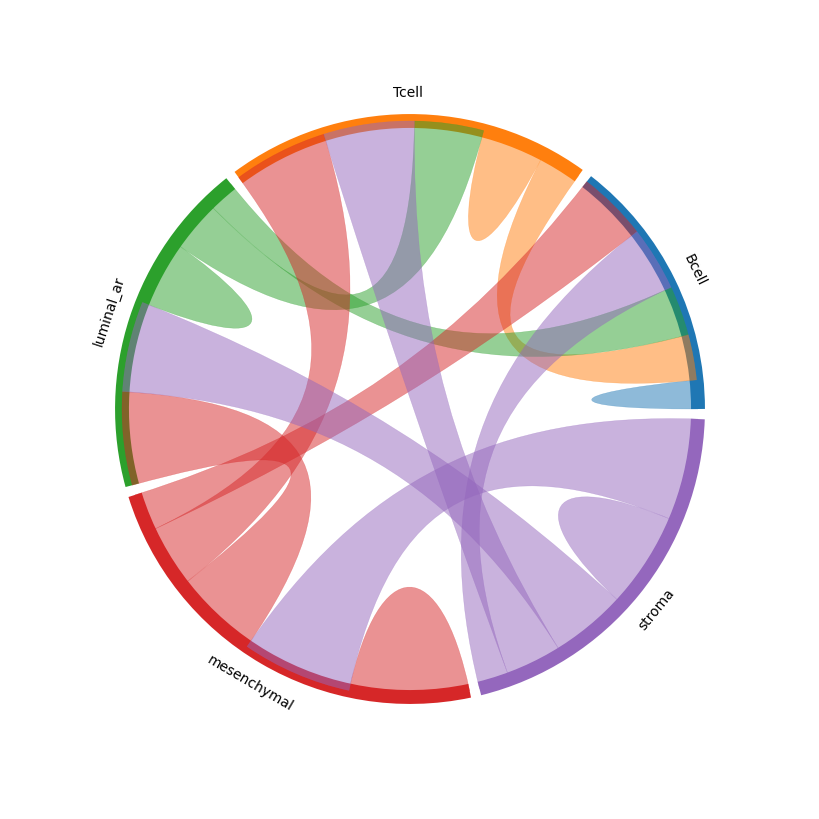

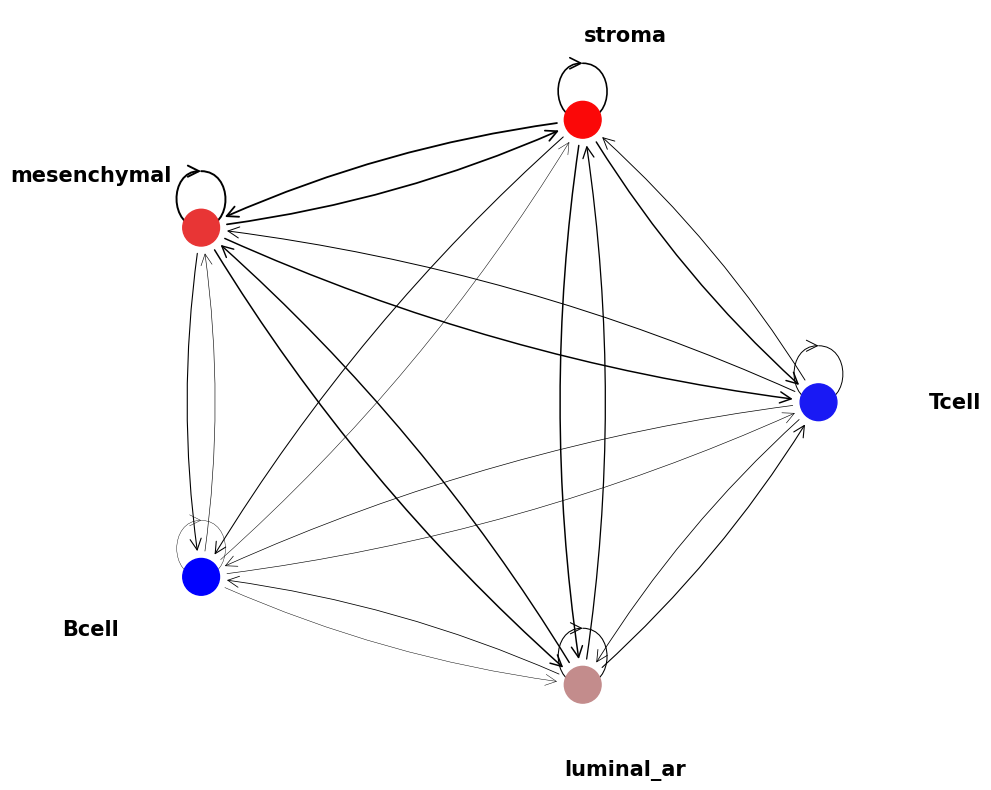

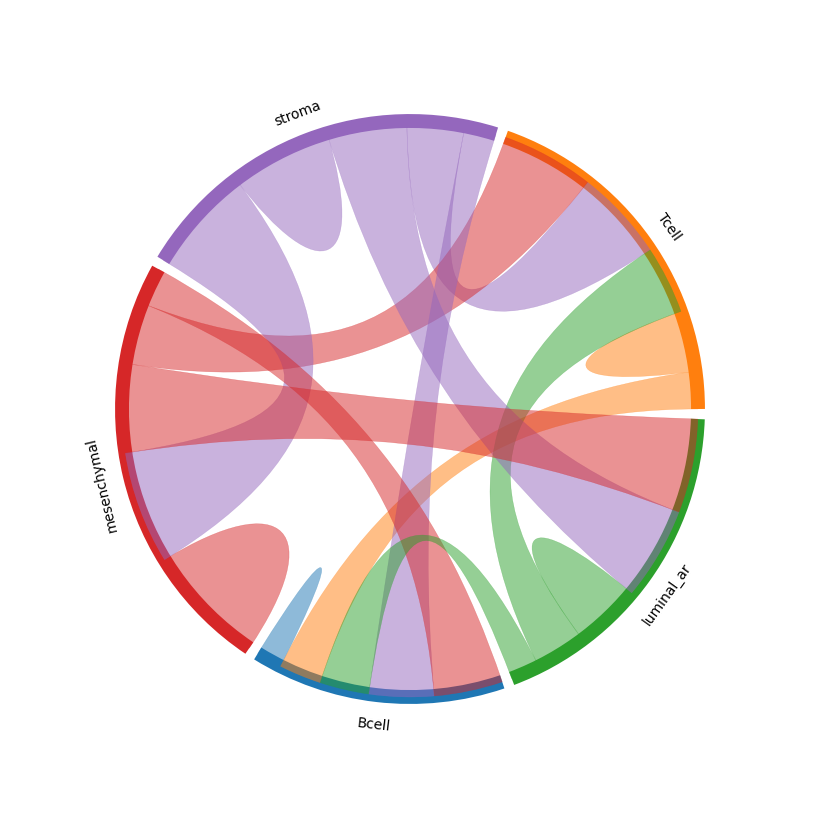

In [9]:
for sample in squidpy_overalls:
    mmcci.plt.network_plot(sample)
    mmcci.plt.chord_plot(sample, colors=colors)

lr_pairs = mmcci.it.get_majority_lr_pairs(squidpy_cci)
squidpy_avg = mmcci.it.get_avg_lr_pairs(squidpy_cci, lr_pairs)
squidpy_overall = mmcci.it.calculate_overall_interactions(squidpy_avg)
mmcci.plt.network_plot(squidpy_overall)
mmcci.plt.chord_plot(squidpy_overall, colors=colors)